In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13/struct1'
os.chdir(new_path)


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Helper functions

In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


### Control parameters

In [4]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [5]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.7e+04


In [6]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [7]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)


### Nodes obtained from LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

In [8]:
# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_lcao[None,...])
remove_pbc(device_basis, S_lcao[None,...])

# Partition the device Hamiltonian matrix into tridiagonal nodes
nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_lcao, len(leads_atoms.repeat(Nr)))

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_lcao, S_lcao)

# Iterate over hs_list_ii and print the shape of each element
for i, matrix in enumerate(hs_list_ii):
    print(f"Shape of hs_list_ii[{i}]: {np.array(matrix).shape}")

# Iterate over hs_list_ij and print the shape of each element
for i, matrix in enumerate(hs_list_ij):
    print(f"Shape of hs_list_ij[{i}]: {np.array(matrix).shape}")


[0, 810, 1116, 1219, 1260, 1566, 2376]
Shape of hs_list_ii[0]: (2, 810, 810)
Shape of hs_list_ii[1]: (2, 306, 306)
Shape of hs_list_ii[2]: (2, 103, 103)
Shape of hs_list_ii[3]: (2, 41, 41)
Shape of hs_list_ii[4]: (2, 306, 306)
Shape of hs_list_ii[5]: (2, 810, 810)
Shape of hs_list_ij[0]: (2, 810, 306)
Shape of hs_list_ij[1]: (2, 306, 103)
Shape of hs_list_ij[2]: (2, 103, 41)
Shape of hs_list_ij[3]: (2, 41, 306)
Shape of hs_list_ij[4]: (2, 306, 810)


### Nodes obtained from Hamiltonian that Subdiagonalizes C, N and H

In [9]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub)
remove_pbc(device_basis, S_sub)

# Partition the device Hamiltonian matrix into tridiagonal nodes
nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub[0], len(leads_atoms.repeat(Nr)))

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_sub[0], S_sub[0])

# Iterate over hs_list_ii and print the shape of each element
for i, matrix in enumerate(hs_list_ii):
    print(f"Shape of hs_list_ii[{i}]: {np.array(matrix).shape}")

# Iterate over hs_list_ij and print the shape of each element
for i, matrix in enumerate(hs_list_ij):
    print(f"Shape of hs_list_ij[{i}]: {np.array(matrix).shape}")

[0, 810, 1116, 1260, 1566, 2376]
Shape of hs_list_ii[0]: (2, 810, 810)
Shape of hs_list_ii[1]: (2, 306, 306)
Shape of hs_list_ii[2]: (2, 144, 144)
Shape of hs_list_ii[3]: (2, 306, 306)
Shape of hs_list_ii[4]: (2, 810, 810)
Shape of hs_list_ij[0]: (2, 810, 306)
Shape of hs_list_ij[1]: (2, 306, 144)
Shape of hs_list_ij[2]: (2, 144, 306)
Shape of hs_list_ij[3]: (2, 306, 810)


### Nodes obtained from Hamiltonian that Subdiagonalizes only C

In [10]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub)
remove_pbc(device_basis, S_sub)

# Partition the device Hamiltonian matrix into tridiagonal nodes
nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub[0], len(leads_atoms.repeat(Nr)))

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_sub[0], S_sub[0])

# Iterate over hs_list_ii and print the shape of each element
for i, matrix in enumerate(hs_list_ii):
    print(f"Shape of hs_list_ii[{i}]: {np.array(matrix).shape}")

# Iterate over hs_list_ij and print the shape of each element
for i, matrix in enumerate(hs_list_ij):
    print(f"Shape of hs_list_ij[{i}]: {np.array(matrix).shape}")

[0, 810, 1116, 1219, 1260, 1566, 2376]
Shape of hs_list_ii[0]: (2, 810, 810)
Shape of hs_list_ii[1]: (2, 306, 306)
Shape of hs_list_ii[2]: (2, 103, 103)
Shape of hs_list_ii[3]: (2, 41, 41)
Shape of hs_list_ii[4]: (2, 306, 306)
Shape of hs_list_ii[5]: (2, 810, 810)
Shape of hs_list_ij[0]: (2, 810, 306)
Shape of hs_list_ij[1]: (2, 306, 103)
Shape of hs_list_ij[2]: (2, 103, 41)
Shape of hs_list_ij[3]: (2, 41, 306)
Shape of hs_list_ij[4]: (2, 306, 810)


### Hard code the nodes to [0, 810, 1116, 1260, 1566, 2376] and look at shape of hslist to see if cutcoupled Hamiltonians have smaller hslist compared to the original subdiagonalized hamiltonian. If they do, then this is likely where the speed up from cut coupling procedure is obtained

In [11]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sub[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub)
remove_pbc(device_basis, S_sub)

# Initialize self-energy list for left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Partition the device Hamiltonian matrix into tridiagonal nodes
nodes = [0, 810, 1116, 1260, 1566, 2376]

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_sub[0], S_sub[0])

# Iterate over hs_list_ii and print the shape of each element
for i, matrix in enumerate(hs_list_ii):
    print(f"Shape of hs_list_ii[{i}]: {np.array(matrix).shape}")

# Iterate over hs_list_ij and print the shape of each element
for i, matrix in enumerate(hs_list_ij):
    print(f"Shape of hs_list_ij[{i}]: {np.array(matrix).shape}")

[0, 810, 1116, 1260, 1566, 2376]
Shape of hs_list_ii[0]: (2, 810, 810)
Shape of hs_list_ii[1]: (2, 306, 306)
Shape of hs_list_ii[2]: (2, 144, 144)
Shape of hs_list_ii[3]: (2, 306, 306)
Shape of hs_list_ii[4]: (2, 810, 810)
Shape of hs_list_ij[0]: (2, 810, 306)
Shape of hs_list_ij[1]: (2, 306, 144)
Shape of hs_list_ij[2]: (2, 144, 306)
Shape of hs_list_ij[3]: (2, 306, 810)


In [12]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sub = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled_device = deepcopy(H_sub)
S_cutcoupled_device = deepcopy(S_sub)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': 3, 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled_device[0], S_cutcoupled_device[0], index_inactive_region)

# Prepare the k-points and matrices for the leads using the cut-coupled Hamiltonian matrix
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device matrices
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

nodes = [0, 810, 1116, 1260, 1566, 2376]

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_cutcoupled_device[0],
    S_cutcoupled_device[0]
)

# Iterate over hs_list_ii and print the shape of each element
for i, matrix in enumerate(hs_list_ii):
    print(f"Shape of hs_list_ii[{i}]: {np.array(matrix).shape}")

# Iterate over hs_list_ij and print the shape of each element
for i, matrix in enumerate(hs_list_ij):
    print(f"Shape of hs_list_ij[{i}]: {np.array(matrix).shape}")

[0, 810, 1116, 1260, 1566, 2376]
Shape of hs_list_ii[0]: (2, 810, 810)
Shape of hs_list_ii[1]: (2, 306, 306)
Shape of hs_list_ii[2]: (2, 144, 144)
Shape of hs_list_ii[3]: (2, 306, 306)
Shape of hs_list_ii[4]: (2, 810, 810)
Shape of hs_list_ij[0]: (2, 810, 306)
Shape of hs_list_ij[1]: (2, 306, 144)
Shape of hs_list_ij[2]: (2, 144, 306)
Shape of hs_list_ij[3]: (2, 306, 810)


### Conclusion
- The shapes of hs_list_*, which is used to compute Green's functions remain unchanged with cut coupling. It is unclear where the speed up due to cut coupling can come from.

- What do the numbers in nodes correspond to?
- What is `graph_partition.tridiagonalize` supposed to do?

When nodes are computed using Hamiltonian subdiagonalized by C, N and H

Nodes = [0, 810, 1116, 1260, 1566, 2376]

Total orbitals of Au = 2232

Total orbitals of Au_left = Total orbitals of Au_right = 1116

Since 1116 - 0 = 2376 - 1260 = 1116 these two values likely pick out the Au orbitals of the left and right leads.

The other values in the nodes list are 810 and 1566. These correspond to the orbitals of the Au atoms that are not included in the Au tip.

The total number of orbitals from C,N and H = 1260-1116 = 144

Therefore, 

0 to 810 = Au left lead orbitals not in tip

810 to 1116 = Au orbitals left tip

1116 to 1260 = C, N, H orbitals

1260 to 1566 = Au orbitals right tip

1566 to 2376 = Au right lead orbitals not in tip

This is the set of nodes that consistently gives us the right T(E)


When nodes are computed using Hamiltonian subdiagonalized by only C or directly from the LCAO Hamiltonian

Nodes = [0, 810, 1116, 1219, 1260, 1566, 2376]. 

We see the appearance of an additional 1219 in the nodes list

Total C orbitals = 78

Total N orbitals = 26

Total H orbitals = 40

1219 - 1116 = 103 

1260 - 1219 = 41

Therefore, 1219 doesn't seem to divide the Hamiltonian in any reasonable atom + orbital blocks. This could explain why the T(E) from Smart Local orbitals is not reproduced correctly with this combination of nodes. This seems to suggest that the `graph_partition.get_tridiagonal_nodes` is meant to pick out chunks of the Hamiltonian that correspond to left lead, bridge and right lead.  It seems like the way to get the right nodes is to use `graph_partition.get_tridiagonal_nodes` with subdiagonalized H and S where the subdiagonalization has to happen over all the bridge molecules.



In [13]:
def construct_H_CN(H, index_C, index_N):
    # Get the size of the submatrix
    size_C = len(index_C)
    size_N = len(index_N)

    # Initialize the H_CN matrix with appropriate size
    size_CN = size_C + size_N
    H_CN = np.zeros((size_CN, size_CN), dtype=H.dtype)

    # Extract C-C submatrix
    H_CN[:size_C, :size_C] = H[np.ix_(index_C, index_C)]

    # Extract N-N submatrix
    H_CN[size_C:, size_C:] = H[np.ix_(index_N, index_N)]

    # Extract C-N submatrix (both C-N and N-C interactions)
    H_CN[:size_C, size_C:] = H[np.ix_(index_C, index_N)]
    H_CN[size_C:, :size_C] = H[np.ix_(index_N, index_C)]

    return H_CN

### Look at C-N coupling blocks, no cut-coupling, subdiagonalize only C atoms

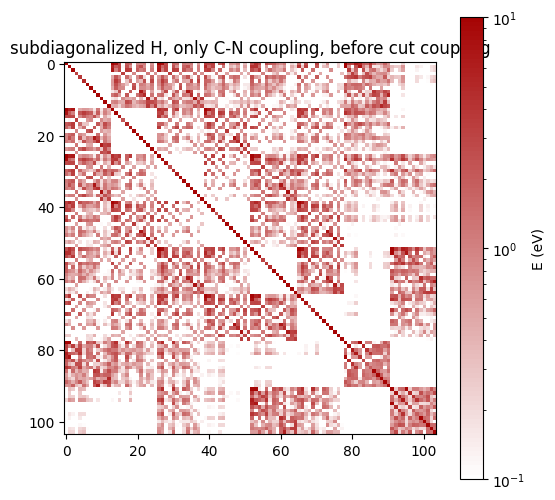

In [14]:
# Define the species for subdiagonalization
SUBDIAG_SPECIES = ("C")

# Get the indices of atoms corresponding to the specified species in the basis
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
N_indices = get_species_indices(atoms, "N")

# Perform subdiagonalization on the Hamiltonian and overlap matrices using the selected species
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the Hamiltonian and overlap matrices using the subdiagonalization matrix
H_sub = rotate_matrix(H_lcao, Usub)
S_sub = rotate_matrix(S_lcao, Usub)

# Extract the basis for the subdiagonalized region and get their indices
basis_C = basis[subdiag_indices]
index_C = basis_C.get_indices()

basis_N = basis[N_indices]
index_N = basis_N.get_indices()

H_CN_Csub = construct_H_CN(H_sub, index_C, index_N)

fig, ax1 = plt.subplots(figsize=(6, 6))  # Create a single subplot

# Plot the matrix with absolute values
cax1 = ax1.imshow(np.abs(H_CN_Csub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("subdiagonalized H, only C-N coupling, before cut coupling")

# Add a colorbar for the single plot
cbar = fig.colorbar(cax1, ax=ax1, orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


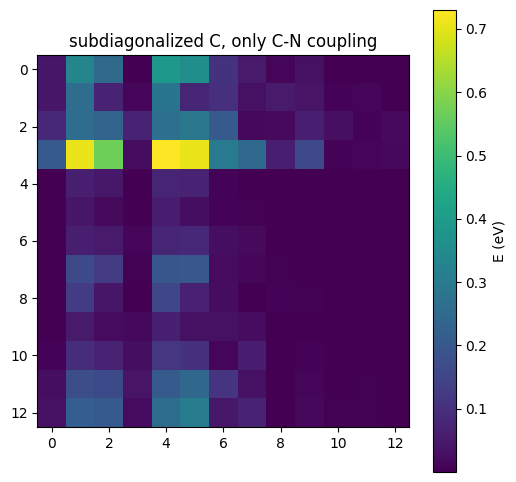

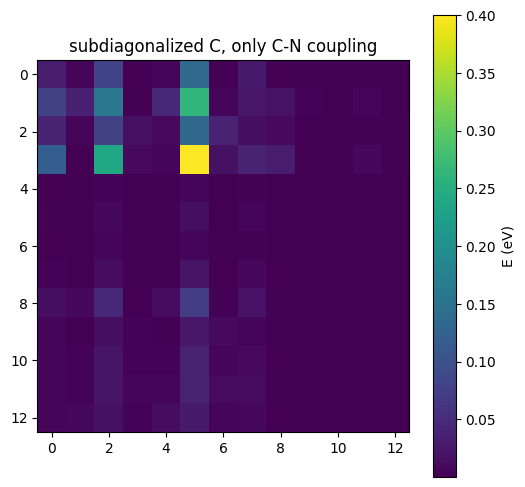

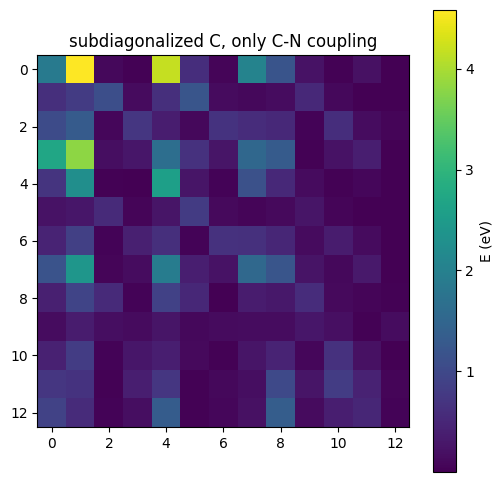

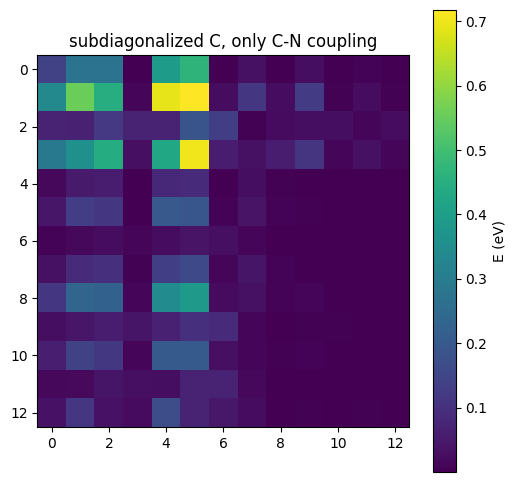

In [15]:
# Plot the matrix with absolute values
for i in range(4):
    fig, ax1 = plt.subplots(figsize=(6, 6))  # Create a single subplot
    jump = i*13
    cax1 = ax1.imshow(np.abs(H_CN_Csub[91:104,0+jump:13+jump]), interpolation='nearest')
    ax1.set_title("subdiagonalized C, only C-N coupling")

    # Add a colorbar for the single plot
    cbar = fig.colorbar(cax1, ax=ax1, orientation='vertical')
    cbar.set_label('E (eV)')

    plt.show()

### Look at C-N coupling blocks, no cut-coupling, subdiagonalize C, N and H atoms

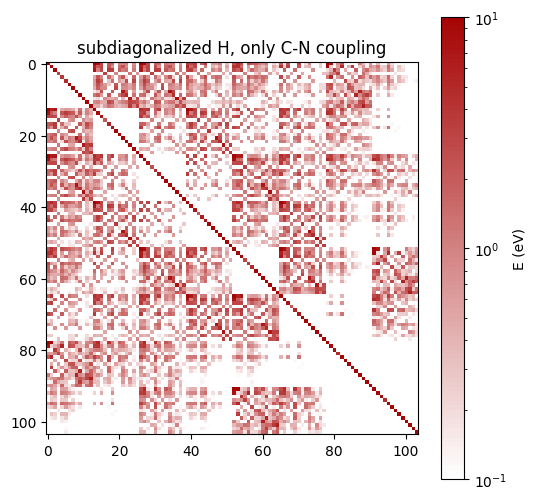

In [16]:
# Define the species for subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")

# Get the indices of atoms corresponding to the specified species in the basis
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
N_indices = get_species_indices(atoms, "N")
C_indices = get_species_indices(atoms, "C")

# Perform subdiagonalization on the Hamiltonian and overlap matrices using the selected species
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the Hamiltonian and overlap matrices using the subdiagonalization matrix
H_sub = rotate_matrix(H_lcao, Usub)
S_sub = rotate_matrix(S_lcao, Usub)

# Extract the basis for the subdiagonalized region and get their indices
basis_C = basis[C_indices]
index_C = basis_C.get_indices()

basis_N = basis[N_indices]
index_N = basis_N.get_indices()

H_CN = construct_H_CN(H_sub, index_C, index_N)

fig, ax1 = plt.subplots(figsize=(6, 6))  # Create a single subplot

# Plot the matrix with absolute values
cax1 = ax1.imshow(np.abs(H_CN), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("subdiagonalized H, only C-N coupling")

# Add a colorbar for the single plot
cbar = fig.colorbar(cax1, ax=ax1, orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


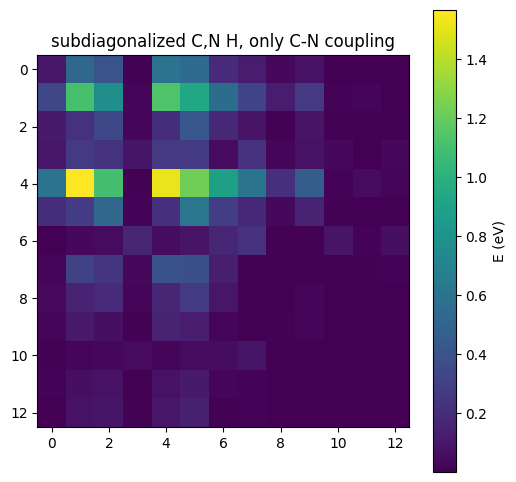

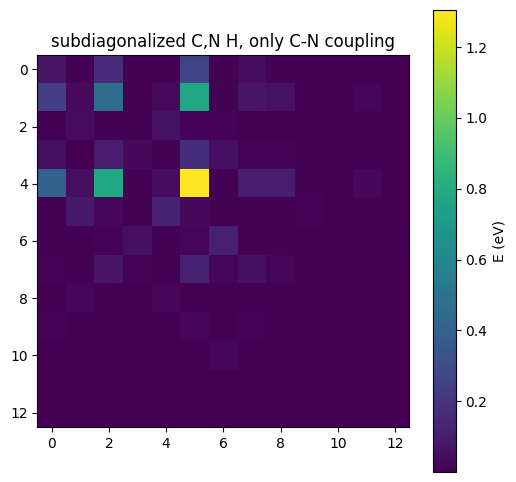

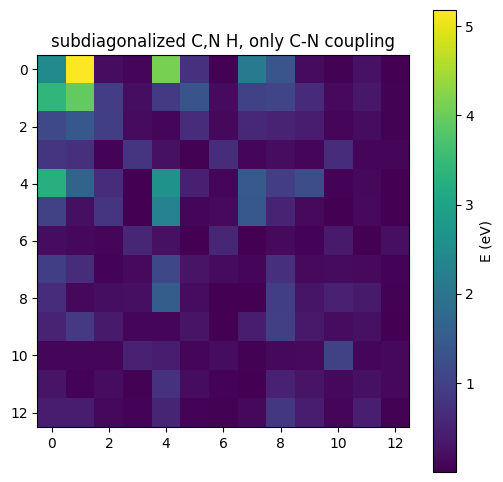

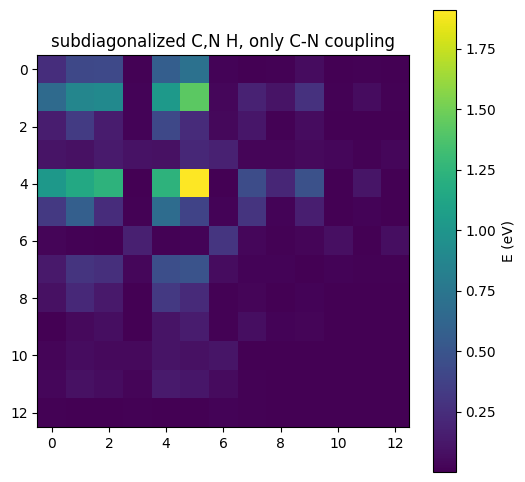

In [17]:
# Plot the matrix with absolute values
for i in range(4):
    fig, ax1 = plt.subplots(figsize=(6, 6))  # Create a single subplot
    jump = i*13
    cax1 = ax1.imshow(np.abs(H_CN[91:104,0+jump:13+jump]), interpolation='nearest')
    ax1.set_title("subdiagonalized C,N H, only C-N coupling")

    # Add a colorbar for the single plot
    cbar = fig.colorbar(cax1, ax=ax1, orientation='vertical')
    cbar.set_label('E (eV)')

    plt.show()